Модель нейронной сети


In [1]:
from google.colab import files
uploaded = files.upload()

Saving tiktok_data.csv to tiktok_data.csv


In [85]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

In [110]:
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

def preprocess_data(df):
    df['duration_seconds'] = df['duration_seconds'] + 1
    df['cleaned_text'] = df['text_part'].fillna('').apply(lambda x: re.sub(r'[^\w\s#@]', ' ', str(x).lower()))
    df['cleaned_hashtags'] = df['hashtags'].fillna('').apply(lambda x: re.sub(r'[^\w\s#]', ' ', str(x).lower()))
    numeric_cols = ['duration_seconds', 'author_followers', 'author_likes', 'views']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce')

    df['human_time'] = pd.to_datetime(df['human_time'], errors='coerce')
    df['hour_sin'] = np.sin(2 * np.pi * df['human_time'].dt.hour/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['human_time'].dt.hour/24)
    df['day_sin'] = np.sin(2 * np.pi * df['human_time'].dt.dayofweek/7)
    df['day_cos'] = np.cos(2 * np.pi * df['human_time'].dt.dayofweek/7)
    df['month_sin'] = np.sin(2 * np.pi * df['human_time'].dt.month/12)
    df['month_cos'] = np.cos(2 * np.pi * df['human_time'].dt.month/12)
    df['text_length'] = df['cleaned_text'].str.len()
    df['hashtags_count'] = df['hashtags'].str.count(' ').fillna(0) + 1

    for col in numeric_cols + ['likes']:
        q = df[col].quantile(0.99)
        df = df[df[col] <= q]

    return df.dropna(subset=numeric_cols + ['likes'])

In [88]:
data = pd.read_csv('tiktok_data.csv')
processed_data = preprocess_data(data)
processed_data

,id_video,duration_seconds,text_part,hashtags,human_time,author_followers,author_likes,id_sound,views,likes,cleaned_text,cleaned_hashtags,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,text_length,hashtags_count
2,3,53.0,NaN,рекомендации,2018-12-30 09:24:42,58400.0,613400.0,7.052607e+18,105100000.0,505300.0,,рекомендации,0.707107,-0.707107,-0.781831,0.623490,-2.449294e-16,1.000000e+00,0,1.0
3,4,61.0,"Учитесь хитрить, как она 😄😉",NaN,2021-03-10 19:57:42,523900.0,11200000.0,6.984582e+18,96700000.0,3000000.0,учитесь хитрить как она,,-0.965926,0.258819,0.974928,-0.222521,1.000000e+00,6.123234e-17,27,1.0
5,6,22.0,Statement ✍️,"tennis, tennistv, atptour, fritz",2018-12-17 19:36:27,1800000.0,138300000.0,7.458512e+18,35800.0,1822.0,statement,tennis tennistv atptour fritz,-0.965926,0.258819,0.000000,1.000000,-2.449294e-16,1.000000e+00,12,4.0
6,7,23.0,Monfils is the ultimate entertainer 🤩,"tennis, tennistv, atptour, monfils",2018-12-17 19:36:27,1800000.0,138300000.0,7.499446e+18,23300.0,1061.0,monfils is the ultimate entertainer,tennis tennistv atptour monfils,-0.965926,0.258819,0.000000,1.000000,-2.449294e-16,1.000000e+00,37,4.0
7,8,61.0,Nope 🙂‍↔️ 🎥 @★𝐌𝐚𝐫𝐢𝐖𝐨𝐫★,NaN,2022-02-20 22:22:46,1800000.0,189100000.0,7.384920e+18,21900000.0,2400000.0,nope @ 𝐌𝐚𝐫𝐢𝐖𝐨𝐫,,-0.500000,0.866025,-0.781831,0.623490,8.660254e-01,5.000000e-01,23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,757,59.0,BREAUNNA's short video with ♬ original sound,NaN,2023-10-28 05:16:45,14100.0,16300000.0,7.445616e+18,696800.0,130000.0,breaunna s short video with original sound,,0.965926,0.258819,-0.974928,-0.222521,-8.660254e-01,5.000000e-01,44,1.0
757,758,41.0,NaN,CapCut,2024-05-30 23:40:02,427800.0,1900000.0,7.491638e+18,177000.0,3991.0,,capcut,-0.258819,0.965926,0.433884,-0.900969,5.000000e-01,-8.660254e-01,0,1.0
758,759,6.0,Me in London 😅 anyone else? 😉 Maybe because I ...,"travel, traveltok, travelhumor",2022-10-06 15:48:17,3676.0,583600.0,7.407876e+18,422500.0,28700.0,me in london anyone else maybe because i ...,travel traveltok travelhumor,-0.707107,-0.707107,0.433884,-0.900969,-8.660254e-01,5.000000e-01,81,3.0
759,760,78.0,NaN,"film, movie, storytime",2025-05-09 16:58:28,86.0,4234.0,7.515855e+18,519800.0,3886.0,,film movie storytime,-0.866025,-0.500000,-0.433884,-0.900969,5.000000e-01,-8.660254e-01,0,3.0


In [ ]:
text_embeddings = get_bert_embeddings(processed_data['cleaned_text'].tolist())
hashtag_embeddings = get_bert_embeddings(processed_data['cleaned_hashtags'].tolist())

In [91]:
numeric_features = ['duration_seconds', 'author_followers', 'author_likes', 'views',
                   'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                   'text_length', 'hashtags_count', 'id_sound']

X_numeric = processed_data[numeric_features]
y = np.log1p(processed_data['likes'])

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    np.hstack([text_embeddings, hashtag_embeddings, X_numeric_scaled]),
    y,
    test_size=0.2,
    random_state=42
)

In [99]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    output = Dense(1)(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

model = create_model(X_train.shape[1])

In [100]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 111.1626 - mae: 9.7622 - val_loss: 101.1222 - val_mae: 9.3545
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 102.6013 - mae: 9.4381 - val_loss: 99.9548 - val_mae: 9.3173
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 101.8533 - mae: 9.4502 - val_loss: 100.0604 - val_mae: 9.3363
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 93.6163 - mae: 9.0696 - val_loss: 94.8404 - val_mae: 9.0713
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 92.2405 - mae: 9.0068 - val_loss: 91.0824 - val_mae: 8.8440
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 86.4507 - mae: 8.7111 - val_loss: 87.3814 - val_mae: 8.6520
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 83.6239 - mae: 8.5400 - val_loss: 81.1507 - val_mae: 8.2980
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 77.9676 - mae: 8.1964 - val_loss: 72.0397 - val_mae: 7.7272
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)

    metrics = {
        'MAE': mean_absolute_error(y_true_exp, y_pred_exp),
        'RMSE': np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)),
        'Mean True Value': np.mean(y_true_exp),
        'RMSE % of Mean': 100 * np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)) / np.mean(y_true_exp),
        'R2 Score': r2_score(y_true_exp, y_pred_exp)
    }

    return metrics

y_pred = model.predict(X_test).flatten()
metrics = evaluate_model(y_test, y_pred)

print("\nМетрики качества модели:")
for name, value in metrics.items():
    if name in ['R2 Score']:
        print(f"{name}: {value:.4f}")
    elif name == 'Mean True Value':
        print(f"{name}: {value:,.2f}")
    else:
        print(f"{name}: {value:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Метрики качества модели:
MAE: 165246.76
RMSE: 456510.94
Mean True Value: 221,027.68
RMSE % of Mean: 206.54
R2 Score: 0.3859


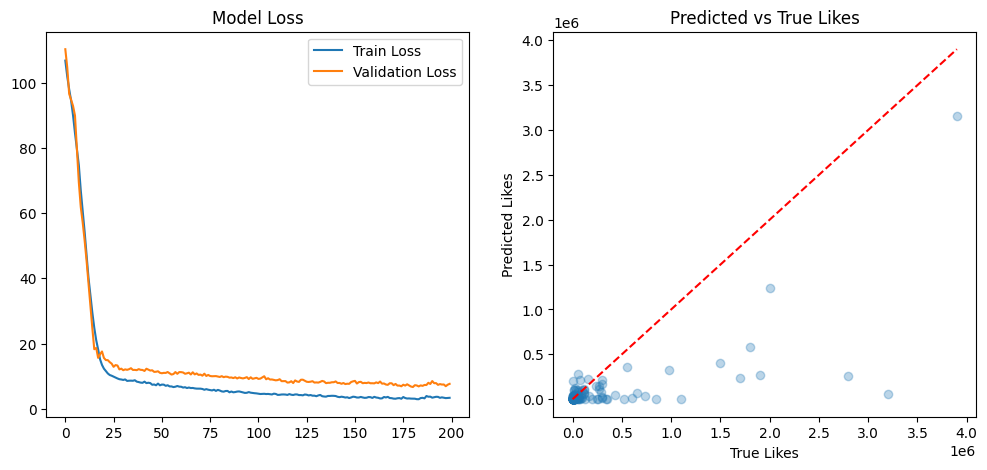

In [96]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.3)
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.xlabel('True Likes')
plt.ylabel('Predicted Likes')
plt.title('Predicted vs True Likes')
plt.show()